In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, cross_val_score
from sklearn.datasets import make_classification
from sklearn import metrics
from imblearn.under_sampling import NearMiss, TomekLinks, OneSidedSelection
from imblearn.under_sampling import CondensedNearestNeighbour, EditedNearestNeighbours, NeighbourhoodCleaningRule
from imblearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

# Undersampling Algorithms for Imbalanced Classification
Different types of Undersampling techniques:
- **Near-Miss** and **Condensed Nearest Neighbor Rules** methods that select examples to keep from the majority class.
- How to use **Tomek Links** and the **Edited Nearest Neighbors Rule** methods that select examples to delete from the majority class.
- How to use **One-Sided Selection** and the **Neighborhood Cleaning Rule** that combine methods for choosing examples to keep and delete from the majority class.

## Undersampling for Imbalanced Classification
An imbalanced class distribution will have one or more classes with few examples (the minority classes) and one or more classes with many examples (the majority classes). It is best understood in the context of a binary (two-class) classification problem where class 0 is the majority class and class 1 is the minority class.

The Undersampling techniques will remove examples from training dataset that belong to majority class in oder to better balance the class distribution, such as reduce the skew from 1:100 to 1:10 or 1:2 or even better 1:1 class distribution.

In [9]:
# create dataset
np.random.seed(1)
X, y = make_classification(n_samples=10_000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
Counter(y)

Counter({0: 9900, 1: 100})

In [10]:
def plotting(X, y):
    plt.figure(figsize=(5, 3))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
    plt.grid()
    plt.show()   

In [5]:
def evaluating(model, X, y, cv, scoring='accuracy'):
    score = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print('Score: % .3f' % score)

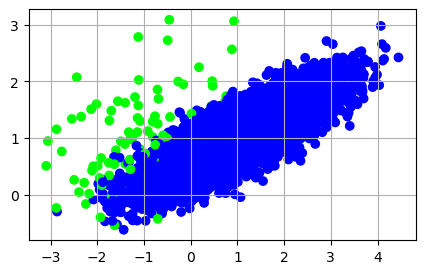

In [11]:
plotting(X, y)

## Near-Miss 
3 versions of this technique: using the Euclidean distance or similar
- NearMiss-1: majority class exmaples with minimum average distance to three closest minority class
- NearMiss-2: Majority class examples with minimum average distance to three furthest minority class examples.
- NearMiss-3: Majority class examples with minimum distance to each minority class example.

In [12]:
# uses version 1 
undersample = NearMiss(version=1, n_neighbors=3)
# transform data
X_new, y_new = undersample.fit_resample(X, y)
Counter(y_new)

Counter({0: 100, 1: 100})

In [ ]:
## selects only those majority class examples that have a minimum distance to three minority class instances, defined by the n_neighbors argument.

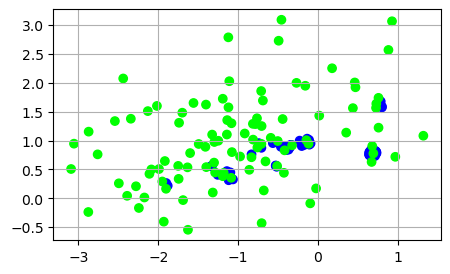

In [13]:
plotting(X_new, y_new)

In [14]:
## using version 2
undersample = NearMiss(version=2, n_neighbors=3)
X_new, y_new = undersample.fit_resample(X, y)
Counter(y_new)

Counter({0: 100, 1: 100})

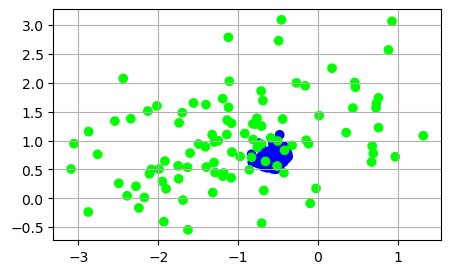

In [16]:
plotting(X_new, y_new)
## It selects examples that are closest to the most distant examples from the minority class, defined by the n_neighbors argument

In [18]:
## version 3
undersample = NearMiss(version=3, n_neighbors=3)
X_new, y_new = undersample.fit_resample(X, y)
Counter(y_new)

Counter({0: 100, 1: 100})

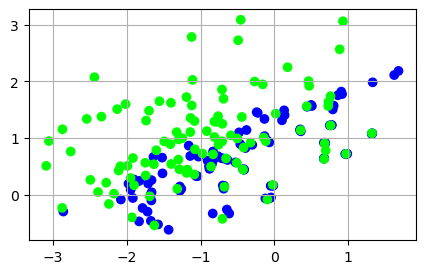

In [19]:
plotting(X_new, y_new)
# each example in the minority class that was in the region of overlap with the majority class has up to three neighbors from the majority class.

## Condensed Nearest Neighbor Rule 
An undersampling technique that seeks a subset of a collection of samples that results in no loss in model performance, referred to as a minimal consistent set.

During the procedure, the KNN algorithm is used to classify points to determine if they are to be added to the store or not. The k value is set via the n_neighbors argument and defaults to 1.

We can see that the resulting distribution is about 1:2 minority to majority examples. This highlights that although the sampling_strategy argument seeks to balance the class distribution, the algorithm will continue to add misclassified examples to the store (transformed dataset). This is a desirable property.

In [21]:
undersample = CondensedNearestNeighbour(n_neighbors=1)
X_new, y_new = undersample.fit_resample(X, y)
Counter(y_new)

Counter({0: 188, 1: 100})

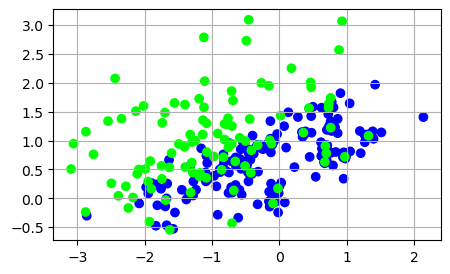

In [22]:
plotting(X_new, y_new)

## Methods that Select exmaples to Delete
### Tomek Links
The procedure for finding Tomek Links can be used to locate all cross-class nearest neighbors. If the examples in the minority class are held constant, the procedure can be used to find all of those examples in the majority class that are closest to the minority class, then removed. These would be the ambiguous examples.

We can see only 26 examples from majority class were deleted. 

This highlights that although finding the ambiguous examples on the class boundary is useful, alone, it is not a great undersampling technique. In practice, the Tomek Links procedure is often combined with other methods, such as the Condensed Nearest Neighbor (CNN) Rule. The choice to combine Tomek Links and CNN is natural, as Tomek Links can be said to remove borderline and noisy instances, while CNN removes redundant instances.

In [23]:
undersample = TomekLinks()
X_new, y_new = undersample.fit_resample(X, y)
Counter(y_new)

Counter({0: 9874, 1: 100})

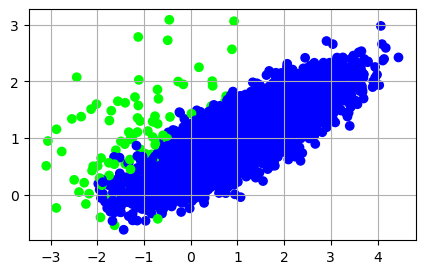

In [24]:
plotting(X_new, y_new)

### Edited Nearest Neighbors Rule
The modified three-nearest neighbor rule which uses the three-nearest neighbor rule to edit the preclassified samples and then uses a single-nearest neighbor rule to make decisions is a particularly attractive rule.

Like Tomek Links, the procedure only removes noisy and ambiguous points along the class boundary. As such, we would not expect the resulting transformed dataset to be balanced.

In [25]:
undersample = EditedNearestNeighbours(n_neighbors=3)
X_new, y_new = undersample.fit_resample(X, y)

In [26]:
Counter(y_new)

Counter({0: 9806, 1: 100})

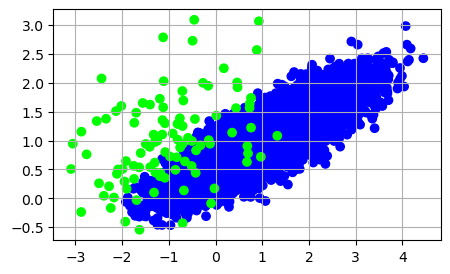

In [27]:
plotting(X_new, y_new)

## Combinations of Keep and Delete methods
### One-Sided Selection for undersampling
One-Sided Selection, or OSS for short, is an undersampling technique that combines Tomek Links and the Condensed Nearest Neighbor (CNN) Rule.

Tomek Links are ambiguous points on the class boundary and are identified and removed in the majority class. The CNN method is then used to remove redundant examples from the majority class that are far from the decision boundary.

The number of seed examples can be set with n_seeds_S and defaults to 1 and the k for KNN can be set via the n_neighbors argument and defaults to 1. Given that the CNN procedure occurs in one block, it is more useful to have a larger seed sample of the majority class in order to effectively remove redundant examples. In this case, we will use a value of 200.

In [28]:
# neighbor=1
undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200) # max seed
X_new, y_new = undersample.fit_resample(X, y)
Counter(y_new)

Counter({0: 953, 1: 100})

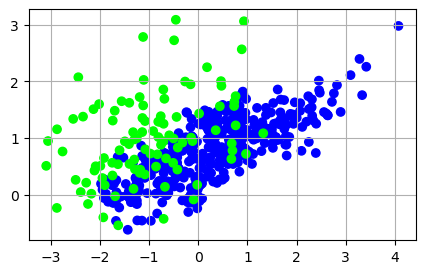

In [29]:
plotting(X_new, y_new)

### Neighborhood Cleaning Rule
The Neighborhood Cleaning Rule, or NCR for short, is an undersampling technique that combines both the Condensed Nearest Neighbor (CNN) Rule to remove redundant examples and the Edited Nearest Neighbors (ENN) Rule to remove noisy or ambiguous examples.

the quality of classification results does not necessarily depend on the size of the class. Therefore, we should consider, besides the class distribution, other characteristics of data, such as noise, that may hamper classification.

The number of neighbors used in the ENN and CNN steps can be specified via the n_neighbors argument that defaults to three. The threshold_cleaning controls whether or not the CNN is applied to a given class, which might be useful if there are multiple minority classes with similar sizes. This is kept at 0.5.

In [37]:
undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
X_new, y_new = undersample.fit_resample(X, y)
Counter(y_new)

Counter({0: 9786, 1: 100})

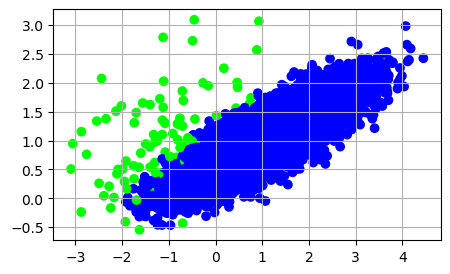

In [38]:
plotting(X_new, y_new)